## Домашнее задание
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### Описание данных
1. recency - months since last purchase
1. history - value of the historical purchases
1. used_discount - indicates if the customer used a discount before
1. used_bogo - indicates if the customer used a buy one get one before
1. zip_code - class of the zip code as Suburban/Urban/Rural
1. is_referral - indicates if the customer was acquired from referral channel
1. channel - channels that the customer using, Phone/Web/Multichannel
1. offer - the offers sent to the customers, Discount/Buy One Get One/No Offer
1. conversion - customer conversion(buy or not)

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!pip install scikit-uplift catboost==0.22 -U
!pip install causalml

     |████████████████████████████████| 64.4MB 68kB/s 
     |████████████████████████████████| 245kB 16.1MB/s 
     |████████████████████████████████| 20.1MB 1.7MB/s 
     |████████████████████████████████| 327kB 56.2MB/s 
     |████████████████████████████████| 1.8MB 44.0MB/s 
     |████████████████████████████████| 634kB 47.1MB/s 
  Created wheel for causalml: filename=causalml-0.10.0-cp37-cp37m-linux_x86_64.whl size=493673 sha256=bae356f650b2465faef08de026cdca063c4133b891c0164c45366d21e55824dd
  Stored in directory: /root/.cache/pip/wheels/81/7f/44/c9d5ecf03f0d950f53302a5eab1c76bec07bcd5868753e22bf
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465042 sha256=e62b539aec7f956051a6fb0b9c43847dd528b61ba922fb229cd95e6cb55ac9e6
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built causalml shap
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
path = "/gdrive/MyDrive/Colab Notebooks/"

In [5]:
data = pd.read_csv(path + 'data.csv')
data

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [6]:
data['offer'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

In [7]:
data.loc[data['offer'] != 'No Offer', 'offer'] = 1
data.loc[data['offer'] == 'No Offer', 'offer'] = 0

In [8]:
data['offer'].value_counts()

1    42694
0    21306
Name: offer, dtype: int64

In [9]:
data = data.rename(columns={'offer': 'treatment', 'conversion': 'target'})

In [10]:
data['target'].value_counts()

0    54606
1     9394
Name: target, dtype: int64

In [11]:
target = data['target']
treatment = data['treatment']
data = data.drop(['target', 'treatment'], axis = 1)

In [12]:
indices_train, indices_valid = train_test_split(data.index, test_size=0.3, random_state=42)

In [13]:
X_train = data.loc[indices_train, :]
y_train = target[indices_train]
treat_train = treatment[indices_train]

X_valid = data.loc[indices_valid, :]
y_valid = target[indices_valid]
treat_valid = treatment[indices_valid]

In [14]:
cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

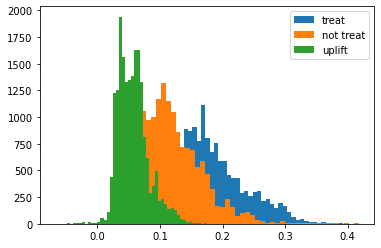

In [15]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier



sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_valid)

sm_score10 = uplift_at_k(y_true=y_valid, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.1)
sm_score20 = uplift_at_k(y_true=y_valid, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score10)
models_results['uplift@20%'].append(sm_score20)

sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_


x = plt.hist(sm_trmnt_preds, bins = 50, label = 'treat')
x = plt.hist(sm_ctrl_preds, bins = 50, label = 'not treat')
x = plt.hist(sm_trmnt_preds - sm_ctrl_preds, bins = 50, label ='uplift')
plt.legend()

In [30]:
pred = sm.predict(X_valid)
pred

array([0.03469982, 0.06100516, 0.09400925, ..., 0.07918185, 0.03536067,
       0.07526681])

In [59]:
y_temp = pd.DataFrame({'pred':pred, 'conv': y_valid})

In [61]:
y_temp['perc'] = pd.qcut(y_temp['pred'], 10)

In [66]:
y_temp.groupby('perc')['conv'].mean()

perc
(-0.0692, 0.029]    0.130208
(0.029, 0.0356]     0.121354
(0.0356, 0.0404]    0.117708
(0.0404, 0.0476]    0.128125
(0.0476, 0.0542]    0.132330
(0.0542, 0.0604]    0.153163
(0.0604, 0.0661]    0.144792
(0.0661, 0.073]     0.163977
(0.073, 0.0901]     0.164412
(0.0901, 0.175]     0.208138
Name: conv, dtype: float64

Были предсказаны значения uplift на валидационной выборке, после чего сгруппированы со значениями conversion. Затем значения uplift были разделены на децили и посчитаны средние значения conversion на каждом интервале. Результат вычислений оиждаемый - чем выже значения uplift, тем выше и значения conversion на данном интервале.

In [17]:
from sklift.models import ClassTransformation

ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_valid)

ct_score10 = uplift_at_k(y_true=y_valid, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.1)
ct_score20 = uplift_at_k(y_true=y_valid, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score10)
models_results['uplift@20%'].append(ct_score20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  after removing the cwd from sys.path.


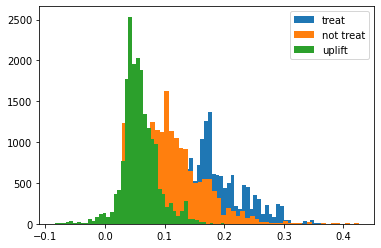

In [19]:
from sklift.models import TwoModels

tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)

tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_valid)

tm_score10 = uplift_at_k(y_true=y_valid, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.1)
tm_score20 = uplift_at_k(y_true=y_valid, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score10)
models_results['uplift@20%'].append(tm_score20)

tm_trmnt_preds = tm.trmnt_preds_
tm_ctrl_preds = tm.ctrl_preds_

x = plt.hist(tm_trmnt_preds, bins = 50, label = 'treat')
x = plt.hist(tm_ctrl_preds, bins = 50, label = 'not treat')
x = plt.hist(tm_trmnt_preds - tm_ctrl_preds, bins = 50, label ='uplift')
plt.legend()

In [67]:
models_results

{'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@10%': [0.10802552711890456, 0.11602714695901853, 0.11111517697485102],
 'uplift@20%': [0.09123127222423663, 0.10971178193053391, 0.09079097715036152]}

In [20]:
X_train_tree = pd.concat([X_train.drop('zip_code', 1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code')], 1)
X_train_tree = pd.concat([X_train_tree.drop('channel', 1), 
                          pd.get_dummies(X_train['channel'], prefix='channel')], 1)
features = [col for col in X_train_tree]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


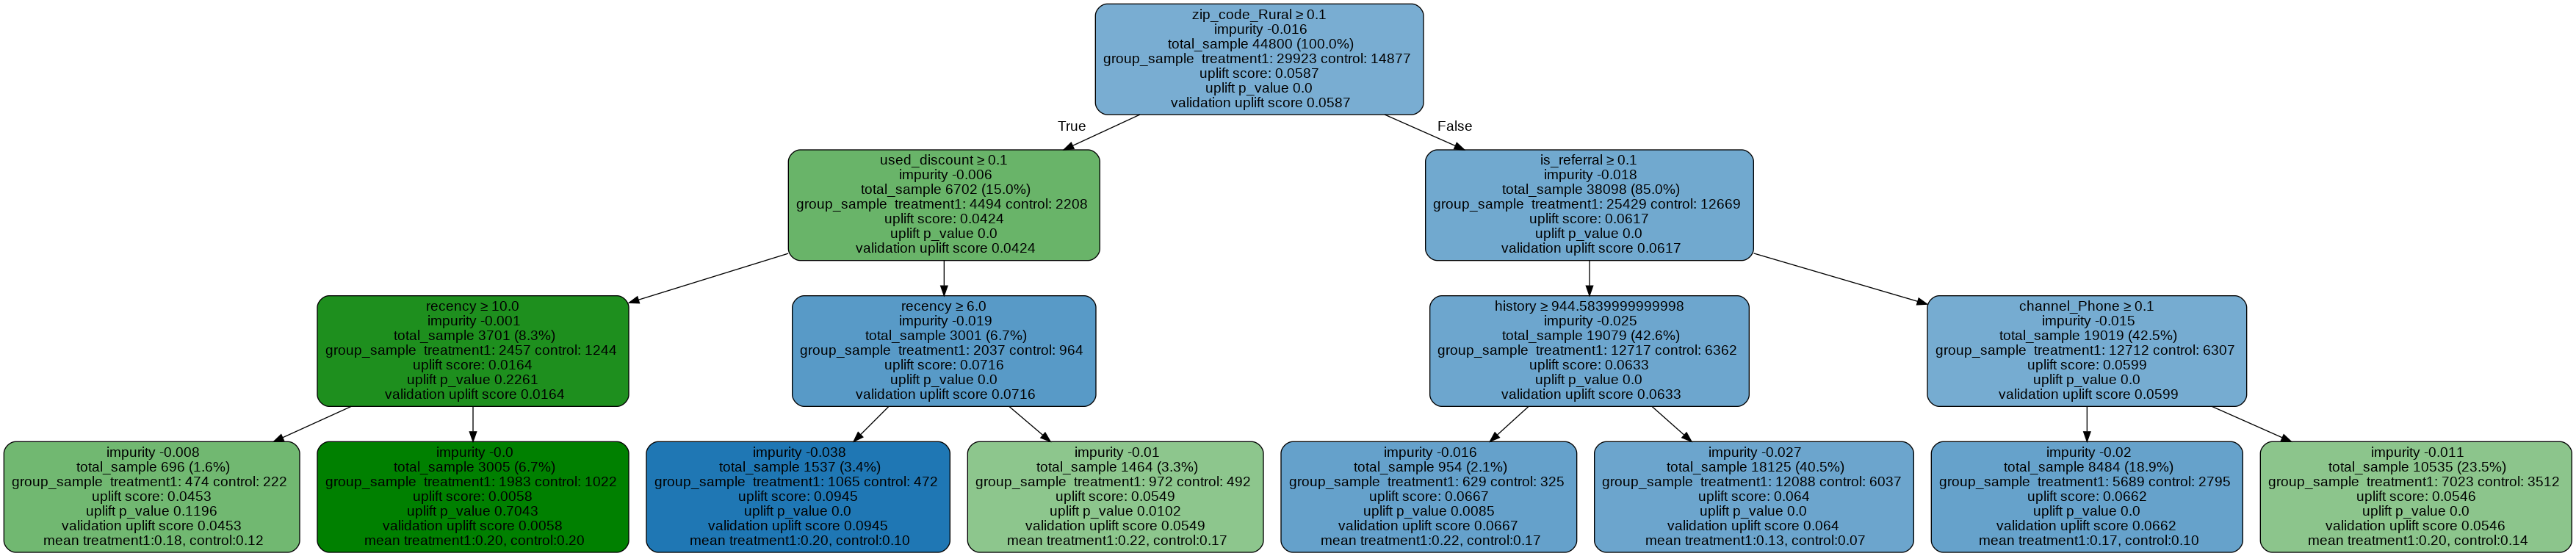

In [21]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

Верхний блок разделяет людей на сельских и несельских жителей. Если человек сельский житель, то проверяется использовал ли он скидки - если нет, то проверяется прошло ли более полугода с последнего заказа, если да, то мы попадаем в самую значимую группу пользователей, для которых достигается максимальное значение uplift, в нем находится в нашем случае 1537 пользователей. Рядом с ним находится самый незначимый в нашем случае блок - если человек сельский житель, при этом он использовал скидку и не делал заказы уже более 10 месяцев, для него значение p_value 70%. Аналогично для остальных блоков.

In [23]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model_rf = UpliftRandomForestClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model_rf.fit(X_train_tree.values, treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values, y=y_train.values)

# graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
# Image(graph.create_png())

In [24]:
X_valid_tree = pd.concat([X_valid.drop('zip_code', 1), 
                          pd.get_dummies(X_valid['zip_code'], prefix='zip_code')], 1)
X_valid_tree = pd.concat([X_valid_tree.drop('channel', 1), 
                          pd.get_dummies(X_valid['channel'], prefix='channel')], 1)

In [25]:
res = uplift_model_rf.predict(X=X_valid_tree.values)

In [26]:
res.mean()

0.05947320594270832

In [28]:
sm_fi = pd.DataFrame({
    'feature_name': features,
    'feature_score': uplift_model_rf.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,recency,0.282257
1,history,0.217025
2,is_referral,0.122882
3,zip_code_Rural,0.092753
4,channel_Phone,0.070817
5,used_bogo,0.054197
6,used_discount,0.048081
7,channel_Web,0.040212
8,zip_code_Surburban,0.034972
9,zip_code_Urban,0.021233


Модель случайного леса показывает, что наиболее важные признаки - время, прошедшее с последней покупки и количество покупок в прошлом.